#Preliminary Steps (Jump to: Fitting a Linear Regression Model Tab)

In [225]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import set_config
set_config(display='diagram')

In [226]:
#Loading data
df = pd.read_csv('/content/sales_predictions.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Getting rid of unnecessary columns

In [227]:
df = df.drop(columns = ['Item_Identifier','Outlet_Identifier','Item_Weight'])

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Fat_Content           8523 non-null   object 
 1   Item_Visibility            8523 non-null   float64
 2   Item_Type                  8523 non-null   object 
 3   Item_MRP                   8523 non-null   float64
 4   Outlet_Establishment_Year  8523 non-null   int64  
 5   Outlet_Size                6113 non-null   object 
 6   Outlet_Location_Type       8523 non-null   object 
 7   Outlet_Type                8523 non-null   object 
 8   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(3), int64(1), object(5)
memory usage: 599.4+ KB


##I see categorical values in the 'Outlet_Size' column that'll need to be imputed.

## Looking for duplicate values.

In [229]:
df.duplicated().sum()

0

In [230]:
columns = df.columns
columns

Index(['Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

# Checking for questionable values. 

In [231]:
for col in columns:
    print(f'{col}:')
    print(df[col].describe())
    print('\n\n')

Item_Fat_Content:
count        8523
unique          5
top       Low Fat
freq         5089
Name: Item_Fat_Content, dtype: object



Item_Visibility:
count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64



Item_Type:
count                      8523
unique                       16
top       Fruits and Vegetables
freq                       1232
Name: Item_Type, dtype: object



Item_MRP:
count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64



Outlet_Establishment_Year:
count    8523.000000
mean     1997.831867
std         8.371760
min      1985.000000
25%      1987.000000
50%      1999.000000
75%      2004.000000
max      2009.000000
Name: Outlet_Establishment_Year, dtype: float64



Outlet_Size:

Checking all column values for nominal or categorical values.

In [232]:
for col in columns:
    print(f'{col}:')
    print(df[col].value_counts())
    print('\n\n')

Item_Fat_Content:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



Item_Visibility:
0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64



Item_Type:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



Item_MRP:
172.0422    7
170.5422    6
196.5084    6
188.1872    6
142.0154    6
           .

##The 'Outlet_Size' and 'Outlet_Location_Type' columns will need to be ordinal encoded and the 'Item_Fat_Content' columns have some questionable values. 

In [233]:
replace = {
'Low':0,
'Small': 1,
'Medium':2,
'High':3
}
df.Outlet_Size.replace(replace, inplace = True)
df.Outlet_Size.value_counts()

2.0    2793
1.0    2388
3.0     932
Name: Outlet_Size, dtype: int64

In [234]:
replais = {
'Tier 1':0,
'Tier 2':1,
'Tier 3':2
}
df.Outlet_Location_Type.replace(replais, inplace = True)
df.Outlet_Location_Type.value_counts()

2    3350
1    2785
0    2388
Name: Outlet_Location_Type, dtype: int64

In [235]:
df.Item_Fat_Content.replace({
'LF':'Low Fat',
'low fat':'Low Fat',
'reg':'Regular'
}, inplace = True)
df.Item_Fat_Content.value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

##Now we can split our data

#Validation Split

In [236]:
y = df.Item_Outlet_Sales
X = df.drop(columns = 'Item_Outlet_Sales')

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

#Instantiating column selectors

In [238]:
#Numeric:
num_selector = make_column_selector(dtype_include = 'number')
num_selector(X_train)

['Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type']

In [239]:
#Categorical
cat_selector = make_column_selector(dtype_include = 'object')
cat_selector(X_train)

['Item_Fat_Content', 'Item_Type', 'Outlet_Type']

#Instantiating transformers

In [240]:
#Imputers
mean_imputer = SimpleImputer(strategy = 'mean')
mfrq_imputer = SimpleImputer(strategy = 'most_frequent')
#OneHotEncoder
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
#Scaler
scaler = StandardScaler()

In [241]:
#Instantiating pipelines
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(mfrq_imputer, ohe)
display(num_pipe)
cat_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Making our ColumnTransformer

In [242]:
#first making our tuples
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

In [243]:
#letting make_column_tranformer take them in (pipeline, column selector) tuple format
preprocessor = make_column_transformer(num_tuple, cat_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb31260efa0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb3198e54f0>)])

#Transforming The Data

In [244]:
#fitting onto our training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb31260efa0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb3198e54f0>)])

In [245]:
#transforming our data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [246]:
display(X_train_processed)
X_test_processed

array([[-0.71277507,  1.82810922,  1.32784893, ...,  0.        ,
         1.        ,  0.        ],
       [-1.29105225,  0.60336888,  1.32784893, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.81331864,  0.24454056,  0.13618724, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.92052713,  1.52302674,  0.49368575, ...,  1.        ,
         0.        ,  0.        ],
       [-0.2277552 , -0.38377708,  1.0895166 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.95867683, -0.73836105, -0.10214509, ...,  1.        ,
         0.        ,  0.        ]])

array([[-0.77664625, -0.99881554, -1.29380678, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.1003166 , -1.58519423, -0.10214509, ...,  1.        ,
         0.        ,  0.        ],
       [-0.48299432, -1.59578435,  0.13618724, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.21832428,  1.09397975,  0.49368575, ...,  1.        ,
         0.        ,  0.        ],
       [-0.77809567, -0.36679966,  0.13618724, ...,  1.        ,
         0.        ,  0.        ],
       [-0.77976293,  0.11221189,  1.0895166 , ...,  1.        ,
         0.        ,  0.        ]])

In [247]:
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('The shape of the data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


The shape of the data is (6392, 27)




array([[-0.71277507,  1.82810922,  1.32784893, ...,  0.        ,
         1.        ,  0.        ],
       [-1.29105225,  0.60336888,  1.32784893, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.81331864,  0.24454056,  0.13618724, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.92052713,  1.52302674,  0.49368575, ...,  1.        ,
         0.        ,  0.        ],
       [-0.2277552 , -0.38377708,  1.0895166 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.95867683, -0.73836105, -0.10214509, ...,  1.        ,
         0.        ,  0.        ]])

# Fitting a Linear Regression Model

In [248]:
#making and fitting our model
linreg_pipe = make_pipeline(preprocessor, LinearRegression())
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb31260efa0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb3198e54f0>)])),
                ('linearregression', LinearRegression())])

Making predictions

In [249]:
y_hat_train = linreg_pipe.predict(X_train)
y_hat_test = linreg_pipe.predict(X_test)

In [250]:
#Creating a function to evaluate the model

In [251]:
def model_eval(y_true, y_pred, set='training'):
    r2 = r2_score(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true,y_pred,squared=False)
#prints our R², MAE, MSE, and RMSE for both splits
    print(f'Results for {set} data:')
    print(f"  - R² = {round(r2,3)}")
    print(f"  - MAE = {round(mae,3)}")
    print(f"  - MSE = {round(mse,3)}")
    print(f"  - RMSE = {round(rmse,3)}")

##Evaluating our Linear Regression Model

In [252]:
model_eval(y_train, y_hat_train,set='training')
model_eval(y_test, y_hat_test,set='test')

Results for training data:
  - R² = 0.561
  - MAE = 847.536
  - MSE = 1300544.784
  - RMSE = 1140.414
Results for test data:
  - R² = 0.566
  - MAE = 805.335
  - MSE = 1197623.654
  - RMSE = 1094.36


• Not only did our model do poor in all metrics, but it suprisingly did equally poor on across all metrics. 

• Using a linear model doesn't seem to be the correct course of action for our data.

• We'll try again with a decision tree model

In [253]:
#Instantiating a decision tree
dec_tree_pipe = make_pipeline(preprocessor, DecisionTreeRegressor(random_state = 42))
#fitting onto our training splits
dec_tree_pipe.fit(X_train, y_train)
#getting predictions for train and test sets
y_hat_train = dec_tree_pipe.predict(X_train)
y_hat_test = dec_tree_pipe.predict(X_test)

##Evaluating our Decision Tree

In [254]:
model_eval(y_train, y_hat_train,set='training')
model_eval(y_test, y_hat_test,set='test')

Results for training data:
  - R² = 1.0
  - MAE = 0.0
  - MSE = 0.0
  - RMSE = 0.0
Results for test data:
  - R² = 0.19
  - MAE = 1032.323
  - MSE = 2234010.817
  - RMSE = 1494.661


• This model has very high variance (and obviously very little bias).

• Our decision tree is very well fit on our training data and is terribly fit on our testing data

• The model will require tuning. 

Looping through a range of max depth values to identify which depth will give us our best score

In [255]:
#create a range of max_depth values
depths = range(1, dec_tree_pipe['decisiontreeregressor'].get_depth())
scores = pd.DataFrame(columns=['Train', 'Test'], index=depths)
for i in depths:
    tree = DecisionTreeRegressor(random_state = 42, max_depth=i)
    tree_pipe = make_pipeline(preprocessor, tree)
    tree_pipe.fit(X_train, y_train)
    train_pred = tree_pipe.predict(X_train)
    test_pred = tree_pipe.predict(X_test)
    train_r2score = r2_score(y_train, train_pred)
    test_r2score = r2_score(y_test, test_pred) 
    #Storing scores in 'scores' 
    scores.loc[i, 'Train'] = train_r2score
    scores.loc[i, 'Test'] = test_r2score

In [256]:
#All scores from our loop
scores

,Train,Test
1,0.237797,0.229683
2,0.431641,0.433778
3,0.524218,0.524222
4,0.582625,0.584005
5,0.603925,0.594747
6,0.614877,0.583674
7,0.625969,0.57831
8,0.641612,0.559304
9,0.663741,0.541027
10,0.684716,0.520672


##Train vs Test Scores Visualized

In [257]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

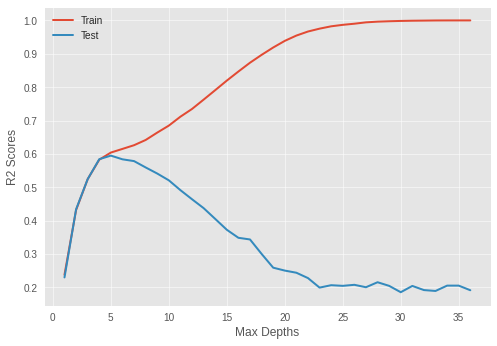

In [258]:
plt.plot(depths, scores['Train'], label = 'Train')
plt.plot(depths, scores['Test'], label = 'Test')
plt.ylabel('R2 Scores')
plt.xlabel('Max Depths')
plt.legend()
plt.style.use('ggplot')
plt.show()

• Our highest score seems to be about 5 but we should check to make sure using the .sort_values() function

In [259]:
new_depth = scores.sort_values(by='Test', ascending=False)
new_depth.head()

,Train,Test
5,0.603925,0.594747
4,0.582625,0.584005
6,0.614877,0.583674
7,0.625969,0.57831
8,0.641612,0.559304


• We now have our best depth for our decision tree. We can now instantiate and evaluate an improved version of the model.

In [260]:
tuned = DecisionTreeRegressor(random_state = 42, max_depth=new_depth.index[0])
tuned_tree_pipe = make_pipeline(preprocessor, tuned)
tuned_tree_pipe.fit(X_train, y_train)

print('Tuned Decision Tree Training Scores')
model_eval(y_train, tuned_tree_pipe.predict(X_train), set = 'training')
print('\n')
print('Tuned Decision Tree Test Scores')
model_eval(y_test, tuned_tree_pipe.predict(X_test), set = 'test')

Tuned Decision Tree Training Scores
Results for training data:
  - R² = 0.604
  - MAE = 762.584
  - MSE = 1172164.969
  - RMSE = 1082.666


Tuned Decision Tree Test Scores
Results for test data:
  - R² = 0.595
  - MAE = 738.338
  - MSE = 1118083.684
  - RMSE = 1057.395


• Although our test score got better, even after tuning, scores are still quite subpar.

• Similarly to our linear regression model, our tuned decision regressor is fit equally poorly onto our training and testing sets. 


#Model of recommendation:

##**Overall, I would recommend the use of the decision tree model. This regressor had a higher R² score for both splits than our linear regressor did (both before and after tuning). The decision tree also had better metrics across the board. It isn't a perfectly fit model by any means, but it is definitely better than the linear model.**

In [261]:
df.columns

Index(['Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')